## Load the data

In [17]:
import datasets
import torch
from math import sqrt

device = 'cuda'
dataset = 'mnist'

# Training parameters
n_latent = 50
n_bins = 51
batch_size = 50
num_epochs = 100
learning_rate = 1e-4
load_models = False

# Download and load the data if needed (MNIST or fashion-MNIST)
train_x, train_labels, test_x, test_labels = datasets.load_mnist() if dataset == 'mnist' else datasets.load_fashion_mnist()

# Normalize the data to be between 0 and 1
train_x = datasets.normalize_min_max(train_x, 0., 1.)
test_x = datasets.normalize_min_max(test_x, 0., 1.)

# Split off the validation set
val_x = train_x[-10000:, :]
train_x = train_x[:-10000, :]
val_labels = train_labels[-10000:]
train_labels = train_labels[:-10000]

# Generate torch tensors from the data
train_x = torch.tensor(train_x).to(device)
test_x = torch.tensor(test_x).to(device)
val_x = torch.tensor(val_x).to(device)
train_N, train_D = train_x.shape

# Determine the number of pixels on one side of the image
img_size = int(sqrt(train_D))

# Determine the number of classes
n_classes = len(set(train_labels))

## Base Encoder

In [18]:
from torch.nn import Conv2d, BatchNorm2d, ELU, Module, ModuleList

class BaseEncoder(Module):
    def __init__(self, n_latent: int, in_channels: int, n_conv_blocks: int, n_filters: int):
        super(BaseEncoder, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.n_latent = n_latent
        conv_head = []
        for i in range(n_conv_blocks):
            conv_head.append(Conv2d(in_channels, n_filters, kernel_size=3, stride=2, padding=1))
            conv_head.append(BatchNorm2d(n_filters))
            conv_head.append(ELU(inplace=True))
            in_channels = n_filters
            n_filters *= 2
        self.conv_head = ModuleList(conv_head)

    def to_latent(self, flattened):
        raise NotImplementedError

    def forward(self, input_x):
        res = input_x
        for layer in self.conv_head:
            res = layer(res)
        res = res.flatten(1)
        return self.to_latent(res)

## Base Decoder

In [19]:
from torch import relu
from torch.nn import Linear, BatchNorm2d, ConvTranspose2d

class BaseDecoder(Module):
    def __init__(self, n_latent: int, n_deconv_blocks: int, in_channels: int, n_fc: int):
        super(BaseDecoder, self).__init__()
        self.in_channels = in_channels
        self.filter_size = int(sqrt(n_fc / in_channels))
        self.dense = Linear(n_latent, n_fc)

        de_conv_head = []
        for i in range(n_deconv_blocks):
            # Don't use output padding for the first block
            out_padding = 0 if i == 0 else 1
            # The last block should output a single channel
            out_channels = 1 if i == n_deconv_blocks - 1 else in_channels // 2
            de_conv_head.append(ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1,
                                                output_padding=out_padding))
            de_conv_head.append(BatchNorm2d(out_channels))
            de_conv_head.append(ELU(inplace=True))
            in_channels = out_channels
        self.de_conv_head = ModuleList(de_conv_head)

    def output(self, deconvoluted):
        raise NotImplementedError

    def reconstruct(self, z):
        raise NotImplementedError

    def forward(self, z):
        # First run the latent vector through a dense layer
        res = relu(self.dense(z))
        # Create a suitable shape for the de-convolution
        res = res.reshape(-1, self.in_channels, self.filter_size, self.filter_size)
        for layer in self.de_conv_head:
            res = layer(res)
        res = res.flatten(1)
        return self.output(res)

## Base VAE

In [20]:
class VAE(Module):
    def __init__(self, encoder: BaseEncoder, decoder: BaseDecoder):
        super(VAE, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.encoder = encoder.to(self.device)
        self.decoder = decoder.to(self.device)

    def elbo(self, x):
        raise NotImplementedError

    def reconstruct(self, x):
        raise NotImplementedError

    def forward(self, x):
        z, _, _ = self.encode(x)
        return self.decode(z)

    def sample(self, n_samples: int):
        with torch.no_grad():
            z = torch.randn(n_samples, self.encoder.n_latent, device=self.device)
            return self.decoder.reconstruct(z)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

# Task 1a

## Build a Gaussian VAE

In [21]:
def kl_loss(mu_z, var_z):
    return torch.mean(0.5 * torch.sum(mu_z**2 + var_z**2 - torch.log(var_z**2) - 1, dim=1))

In [22]:
class GaussianEncoder(BaseEncoder):
    def __init__(self, n_latent: int, in_channels=1, n_conv_blocks=3, n_filters=32, n_fc=2048):
        super(GaussianEncoder, self).__init__(n_latent, in_channels, n_conv_blocks, n_filters)

        # Mean and variance layers
        self.mu = Linear(n_fc, n_latent)
        self.var = Linear(n_fc, n_latent)
        self.var_act = Softplus()

    def reparameterize(self, mu, var):
        return mu + torch.sqrt(var) * torch.randn(var.shape, device=self.device)

    def to_latent(self, flattened):
        mu = self.mu(flattened)
        var = self.var_act(self.var(flattened))
        z = self.reparameterize(mu, var)
        return z, mu, var

In [23]:
from torch.distributions import Normal
from torch.nn import Softplus

class GaussianDecoder(BaseDecoder):

    def __init__(self, n_pixels: int, n_latent: int, n_deconv_blocks=3, in_channels=128, n_fc=2048, var=0.05):
        super(GaussianDecoder, self).__init__(n_latent, n_deconv_blocks, in_channels, n_fc)
        self.n_latent = n_latent
        self.in_channels = in_channels
        self.filter_size = int(sqrt(n_fc / in_channels))
        self.var = var

        # Generate the output layer
        self.mu = Linear(n_pixels, n_pixels)

    def output(self, deconvoluted):
        return self.mu(deconvoluted)

    def reconstruct(self, z):
        mu = self.forward(z)
        x_hat = Normal(mu, self.var).sample()
        return x_hat

In [24]:
class GaussianVAE(VAE):
    def __init__(self, n_latent: int, n_pixels: int):
        super().__init__(GaussianEncoder(n_latent), GaussianDecoder(n_pixels, n_latent))
        self.n_latent = n_latent

    def elbo(self, x):
        z, mu_z, var_z = self.encode(x)
        x_decoded = self.decode(z)

        recon = x_decoded
        mse = (recon - x.flatten(1))**2
        recon_loss = 0.5 * torch.sum(np.log(self.decoder.var * 2 * np.pi) + mse / self.decoder.var)

        return recon_loss + kl_loss(mu_z, var_z)

    def reconstruct(self, x):
        return self.forward(x)

In [25]:
def print_vae_params(vae: VAE):
    print(vae_gaussian.encoder)
    print(vae_gaussian.decoder)
    print(f'Number of encoder parameters: {sum(p.numel() for p in vae_gaussian.encoder.parameters())}')
    print(f'Number of decoder parameters: {sum(p.numel() for p in vae_gaussian.decoder.parameters())}')

In [26]:
vae_gaussian = GaussianVAE(n_latent, train_D)
print_vae_params(vae_gaussian)

GaussianEncoder(
  (conv_head): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0, inplace=True)
  )
  (mu): Linear(in_features=2048, out_features=50, bias=True)
  (var): Linear(in_features=2048, out_features=50, bias=True)
  (var_act): Softplus(beta=1, threshold=20)
)
GaussianDecoder(
  (dense): Linear(in_features=50, out_features=2048, bias=True)
  (de_conv_head): ModuleList(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 

# Task 1b & 1c

## Early Stopping

In [27]:
class EarlyStopping:
    def __init__(self, threshold: float, patience=3):
        """
        :param threshold: The loss decrease threshold to consider for early stopping
        :param patience: The number of epochs to wait before stopping
        """
        self.threshold = threshold
        self.patience = patience
        self.last_loss = float("inf")
        self.counter = 0

    def __call__(self, loss: float) -> bool:
        """
        :param loss: The current loss
        :return: True if the training should stop, False otherwise
        """
        if loss >= self.last_loss or self.last_loss - loss < self.threshold:
            self.counter += 1
        else:
            self.counter = 0
        self.last_loss = loss
        return self.counter >= self.patience

## Model Loading

In [28]:
def load_weights(model: Module, dist_type: str, model_type: str):
    model.load_state_dict(pickle.load(open(f"models/{dist_type}/{model_type}.pkl", "rb")))

## Generic VAE training method

In [29]:
from typing import List, Tuple

def train_vae(vae: VAE, stop_early: EarlyStopping) -> Tuple[List, List]:

    # Use Adam as the optimizer for both the encoder and decoder
    optimizer = torch.optim.Adam(list(vae.decoder.parameters()) + list(vae.encoder.parameters()), lr=learning_rate)

    train_loss_history = []
    val_loss_history = []
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        vae.train()
        train_loss, val_loss = 0, 0
        # Sample batches of training indices
        shuffled_idx = torch.randperm(train_x.shape[0])
        idx_batches = shuffled_idx.split(batch_size)
        for batch_count, idx in enumerate(idx_batches):
            optimizer.zero_grad()
            batch_x = train_x[idx, :]
            input_x = batch_x.reshape(batch_size, img_size, img_size).unsqueeze(1)

            loss = vae.elbo(input_x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss_history.append(train_loss / train_x.shape[0])
        
        with torch.no_grad():
            vae.eval()
            shuffled_idx = torch.randperm(val_x.shape[0])
            idx_batches = shuffled_idx.split(batch_size)
            for batch_count, idx in enumerate(idx_batches):
                batch_x = train_x[idx, :]
                input_x = batch_x.reshape(batch_size, img_size, img_size).unsqueeze(1)

                loss = vae.elbo(input_x)
                val_loss += loss.item()

            val_loss_history.append(val_loss / val_x.shape[0])

        pbar.set_postfix({'Train Loss': train_loss, 'Validation Loss': val_loss})

        if stop_early(train_loss_history[-1]):
            print(f'Training criterion reached at epoch {epoch}. Stopping training...')
            # Store the model weights
            pickle.dump(vae.encoder.state_dict(), open(f"models/{dist_type}/encoder.pkl", "wb"))
            pickle.dump(vae.decoder.state_dict(), open(f"models/{dist_type}/decoder.pkl", "wb"))
            break
    return train_loss_history, val_loss_history

## Train the Gaussian VAE

In [30]:
import numpy as np
from tqdm import tqdm
import pickle

stop_threshold = 1
dist_type = 'gaussian'

if load_models:
    load_weights(vae_gaussian.encoder, dist_type, 'encoder')
    load_weights(vae_gaussian.decoder, dist_type, 'decoder')
else:
    print(f'Training a new Gaussian VAE...')
    # Use early stopping to stop training when the validation loss stops improving
    stop_early = EarlyStopping(stop_threshold)
    gaussian_train_loss, gaussian_val_loss = train_vae(vae_gaussian, stop_early)

Training a new Gaussian VAE...


 21%|▏| 21/100 [02:19<08:45,  6.65s/it, Train Loss=-1.95e+7, Validation Loss=-3.

Training criterion reached at epoch 21. Stopping training...


## Method to plot the training and validation losses

In [31]:
from typing import List
from matplotlib import pyplot as plt

def plot_ELBO(train_loss_history: List, val_loss_history: List):
    """
    Plot the ELBO curves
    :param train_loss_history: list of training loss values
    :param val_loss_history: list of validation loss values
    :param save_path: path to save the plot to
    """
    plt.style.use('seaborn')
    plt.plot([i * -1 for i in train_loss_history])
    plt.plot([i * -1 for i in val_loss_history])
    plt.legend(["Training", "Validation"])
    plt.xlabel("Epoch")
    plt.ylabel("ELBO")
    plt.show()

## Plot the Gaussian VAE ELBO

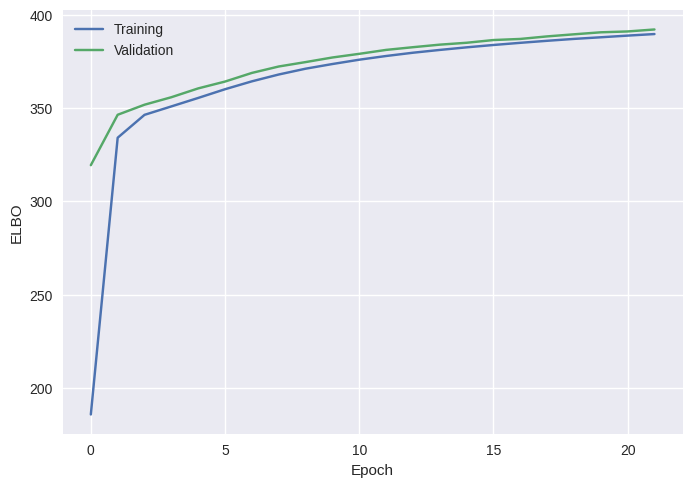

In [32]:
plot_ELBO(gaussian_train_loss, gaussian_val_loss)

# Task 1d

## Generic method for plotting reconstructions and samples

In [33]:
from PIL import Image
from itertools import chain

def plot_reconstruction(vae: VAE, n_samples: int, img_size: int, samples=None, reconstruct=False):
    if reconstruct:
        samples = samples.reshape(n_samples, img_size, img_size)
        x = samples.unsqueeze(1)

        x_hat = vae.reconstruct(x)
        x_hat = x_hat.reshape(n_samples, img_size, img_size).detach().cpu().numpy()

        x = x.squeeze().detach().cpu().numpy()
        plot_images = list(chain.from_iterable(zip(x, x_hat)))
    else:
        samples = vae.sample(n_samples)
        samples = samples.reshape(n_samples, img_size, img_size)
        plot_images = samples.detach().cpu().numpy()

    height = samples.shape[1]
    width = samples.shape[2]

    num_columns = 8
    num_rows = len(plot_images) // num_columns
    frame = 2
    frame_gray_val = 1.0
    margin = 5
    margin_gray_val = 1.0

    img = margin_gray_val * np.ones((height * num_rows + (num_rows - 1) * margin,
                                     width * num_columns + (num_columns - 1) * margin))
    counter = 0
    for h in range(num_rows):
        for w in range(num_columns):
            img[h * (height + margin): h * (height + margin) + height,
            w * (width + margin): w * (width + margin) + width] = plot_images[counter]
            counter += 1

    framed_img = frame_gray_val * np.ones((img.shape[0] + 2 * frame, img.shape[1] + 2 * frame))
    framed_img[frame:(frame + img.shape[0]), frame:(frame + img.shape[1])] = img

    plt.style.use('default')
    plt.imshow(framed_img)

## Plot the Gaussian VAE reconstructions

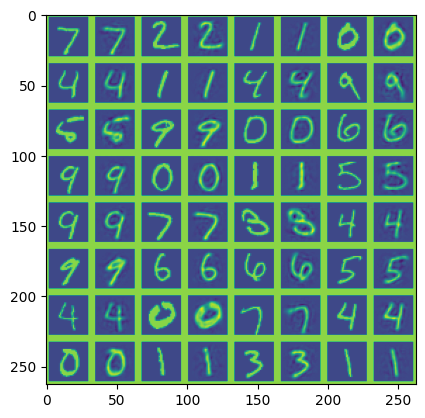

In [34]:
n_samples = 32
test_samples = test_x[0:n_samples :]

# Plot the reconstruction of test images
plot_reconstruction(vae_gaussian, n_samples, img_size, test_samples, reconstruct=True)

## Plot the Gaussian VAE samples

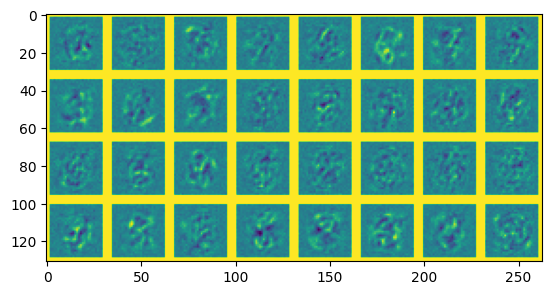

In [35]:
# Generate new images by sampling from the latent space
plot_reconstruction(vae_gaussian, n_samples, img_size, reconstruct=False)

# Task 2a

# Task 2b

## Build a Beta VAE

The Encoder remains the same.  
The Decoder now outputs the Beta Distribution parameters (alpha and beta) for each pixel.  
We use the built-in torch Beta distribution for sampling.

In [36]:
class BetaDecoder(BaseDecoder):
    def __init__(self, n_pixels: int, n_latent: int, n_deconv_blocks=3, in_channels=128, n_fc=2048):
        super(BetaDecoder, self).__init__(n_latent, n_deconv_blocks, in_channels, n_fc)
        self.n_pixels = n_pixels
        self.n_latent = n_latent

        self.alpha = Linear(n_pixels, n_pixels)
        self.beta = Linear(n_pixels, n_pixels)
        self.act = Softplus()

    def output(self, deconvoluted):
        # Output the parameters of the Beta Distribution
        alpha = self.act(self.alpha(deconvoluted))
        beta = self.act(self.beta(deconvoluted))
        return alpha, beta

    def reconstruct(self, z):
        alpha, beta = self.forward(z)
        variance = (alpha * beta) / ((alpha + beta).pow(2) * (alpha + beta + 1))
        return alpha / (alpha + beta) + variance * torch.randn_like(variance)

In [37]:
class BetaVAE(VAE):
    def __init__(self, n_latent: int, n_pixels: int):
        super().__init__(GaussianEncoder(n_latent), BetaDecoder(n_pixels, n_latent))
        self.n_latent = n_latent

    def elbo(self, x):
        z, mu, var = self.encode(x)
        alpha, beta = self.decode(z)

        log_likelihood = torch.sum(log_beta_pdf(x.flatten(1), alpha, beta))
        return kl_loss(mu, var) - log_likelihood

    def reconstruct(self, x):
        alpha, beta = self.forward(x)
        variance = (alpha * beta) / ((alpha + beta).pow(2) * (alpha + beta + 1))
        return alpha / (alpha + beta) + variance * torch.randn_like(variance)

In [38]:
vae_beta = BetaVAE(n_latent, train_D)
print_vae_params(vae_beta)

GaussianEncoder(
  (conv_head): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0, inplace=True)
  )
  (mu): Linear(in_features=2048, out_features=50, bias=True)
  (var): Linear(in_features=2048, out_features=50, bias=True)
  (var_act): Softplus(beta=1, threshold=20)
)
GaussianDecoder(
  (dense): Linear(in_features=50, out_features=2048, bias=True)
  (de_conv_head): ModuleList(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 

## Train the Beta VAE and plot the results

In [39]:
def log_beta_pdf(x, alpha, beta, eps=1e-8):
    """
    Calculate the log pdf of a beta distribution
    :param batch_x: batch of samples from the beta distribution
    :param alpha: alpha parameter of the beta distribution
    :param beta: beta parameter of the beta distribution
    :param eps: epsilon to avoid numerical issues when taking logarithms
    :return: log pdf of the beta distribution
    """
    return torch.lgamma(alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta) + \
        (alpha - 1) * torch.log(x + eps) + (beta - 1) * torch.log(1 - x + eps)

In [40]:
stop_threshold = 5
dist_type = 'beta'

if load_models:
    load_weights(vae_beta.encoder, dist_type, 'encoder')
    load_weights(vae_beta.decoder, dist_type, 'decoder')
else:
    print(f'Training a new {dist_type} VAE...')
    # Use early stopping to stop training when the validation loss stops improving
    stop_early = EarlyStopping(stop_threshold)
    beta_train_loss, beta_val_loss = train_vae(vae_beta, stop_early)

Training a new beta VAE...


 17%|▏| 17/100 [02:07<10:22,  7.50s/it, Train Loss=-4.77e+8, Validation Loss=-9.

Training criterion reached at epoch 17. Stopping training...


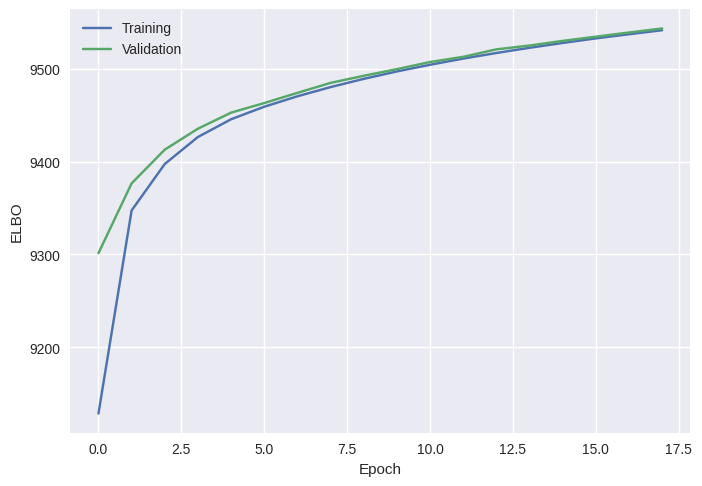

In [41]:
# Plot the training and validation loss curves
plot_ELBO(beta_train_loss, beta_val_loss)

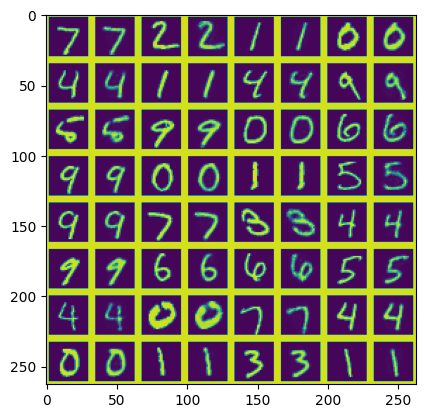

In [42]:
# Plot the reconstruction of test images
plot_reconstruction(vae_beta, n_samples, img_size, test_samples, reconstruct=True)

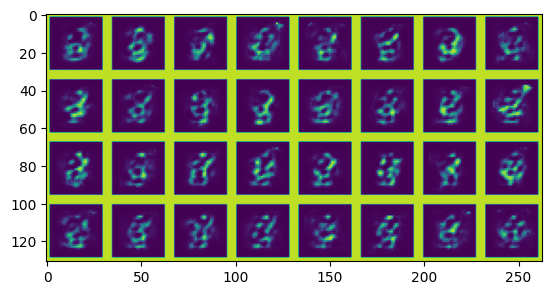

In [43]:
# Generate new images by sampling from the latent space
plot_reconstruction(vae_beta, n_samples, img_size, reconstruct=False)

# Task 2c

In [44]:
from torch.nn import Softmax

class CategoricalDecoder(BaseDecoder):
    def __init__(self, n_pixels: int, n_latent: int, n_bins: int, n_deconv_blocks=3, in_channels=128, n_fc=2048):
        super(CategoricalDecoder, self).__init__(n_latent, n_deconv_blocks, in_channels, n_fc)
        self.n_bins = n_bins
        self.n_pixels = n_pixels
        self.n_latent = n_latent

        self.out = Linear(n_pixels, n_pixels * n_bins)
        self.act = Softmax(dim=2)

    def output(self, deconvoluted):
        out = self.out(deconvoluted)
        out = out.reshape(-1, self.n_pixels, self.n_bins)
        out = self.act(out)
        return out

    def reconstruct(self, z):
        pmf = self.forward(z)
        dist = Categorical(pmf)
        return dist.sample() / self.n_bins

In [45]:
from torch.distributions import Categorical
from torch.nn.functional import one_hot

class CategoricalVAE(VAE):

    def __init__(self, n_latent: int, n_pixels: int, n_bins: int):
        super().__init__(GaussianEncoder(n_latent), CategoricalDecoder(n_pixels, n_latent, n_bins))
        self.n_latent = n_latent

    def forward(self, x):
        x_cat = torch.floor(x * (self.decoder.n_bins - 1))
        return super().forward(x_cat)

    def elbo(self, x):
        x = torch.floor(x * (self.decoder.n_bins - 1))
        z, mu_z, var_z = self.encode(x)
        pmf = self.decode(z)

        one_hot_x = one_hot(x.flatten(1).to(torch.int64), num_classes=self.decoder.n_bins)
        log_likelihood = torch.sum(torch.log(pmf) * one_hot_x)
        return kl_loss(mu_z, var_z) - log_likelihood

    def sample(self, n_samples: int):
        with torch.no_grad():
            z = torch.randn(n_samples, self.n_latent, device=self.device)
            return self.decoder.reconstruct(z)

    def reconstruct(self, x):
        pmf = self.forward(x)
        dist = Categorical(pmf)
        return dist.sample() / self.decoder.n_bins

In [46]:
n_bins = 51
vae_categorical = CategoricalVAE(n_latent, train_D, n_bins)
print_vae_params(vae_categorical)

GaussianEncoder(
  (conv_head): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0, inplace=True)
  )
  (mu): Linear(in_features=2048, out_features=50, bias=True)
  (var): Linear(in_features=2048, out_features=50, bias=True)
  (var_act): Softplus(beta=1, threshold=20)
)
GaussianDecoder(
  (dense): Linear(in_features=50, out_features=2048, bias=True)
  (de_conv_head): ModuleList(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 

In [47]:
stop_threshold = 10
dist_type = 'categorical'

if load_models:
    load_weights(vae_categorical.encoder, dist_type, 'encoder')
    load_weights(vae_categorical.decoder, dist_type, 'decoder')
else:
    print(f'Training a new {dist_type} VAE...')
    # Use early stopping to stop training when the validation loss stops improving
    stop_early = EarlyStopping(stop_threshold)
    categorical_train_loss, categorical_val_loss = train_vae(vae_categorical, stop_early)

Training a new categorical VAE...


  9%| | 9/100 [06:01<54:47, 36.12s/it, Train Loss=1.88e+7, Validation Loss=3.64e

Training criterion reached at epoch 9. Stopping training...


  9%| | 9/100 [06:01<1:00:55, 40.17s/it, Train Loss=1.88e+7, Validation Loss=3.6


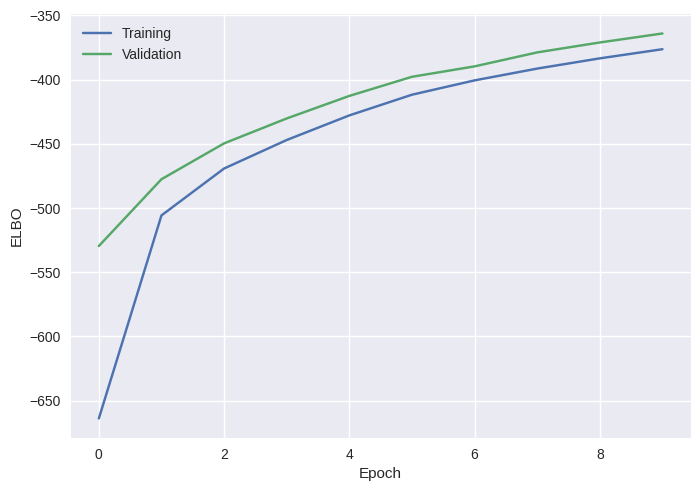

In [48]:
# Plot the training and validation loss curves
plot_ELBO(categorical_train_loss, categorical_val_loss)

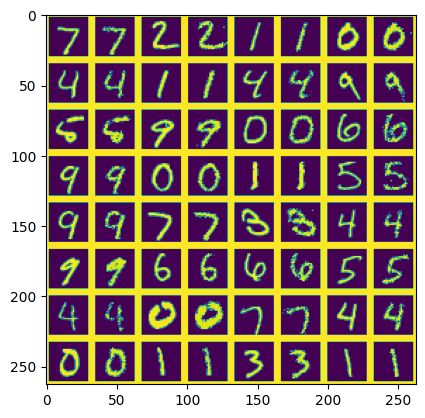

In [49]:
# Plot the reconstruction of test images
plot_reconstruction(vae_categorical, n_samples, img_size, test_samples, reconstruct=True)

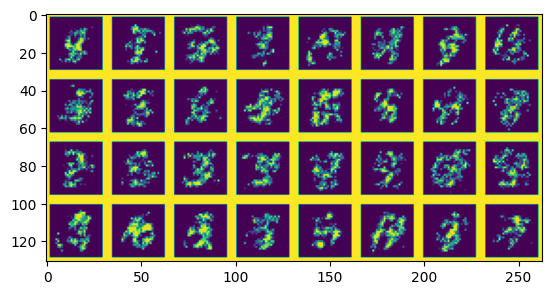

In [50]:
# Generate new images by sampling from the latent space
plot_reconstruction(vae_categorical, n_samples, img_size, reconstruct=False)

# Task 2d

In [51]:
from torch.nn import Sigmoid

class BernoulliDecoder(BaseDecoder):
    def __init__(self, n_pixels: int, n_latent: int, n_deconv_blocks=3, in_channels=128, n_fc=2048, var=0.05):
        super(BernoulliDecoder, self).__init__(n_latent, n_deconv_blocks, in_channels, n_fc)
        self.n_latent = n_latent
        self.out = Linear(n_pixels, n_pixels)
        self.out_act = Sigmoid()

    def output(self, deconvoluted):
        return self.out_act(self.out(deconvoluted))

    def reconstruct(self, z):
        pmf = self.forward(z)
        return torch.bernoulli(pmf)

In [52]:
class BernoulliVAE(VAE):
    def __init__(self, n_latent: int, n_pixels: int):
        super().__init__(GaussianEncoder(n_latent), BernoulliDecoder(n_pixels, n_latent))
        self.n_latent = n_latent

    def forward(self, x):
        x_binary = torch.bernoulli(x)
        return super().forward(x_binary)

    def elbo(self, x):
        x_binary = torch.bernoulli(x)
        z, mu_z, var_z = self.encode(x_binary)
        pmf = self.decode(z)
        entropy_loss = torch.mean(
            torch.sum(x.flatten(1) * torch.log(pmf) + (1 - x.flatten(1)) * torch.log(1 - pmf), dim=1))
        return kl_loss(mu_z, var_z) - entropy_loss

    def reconstruct(self, x):
        pmf = self.forward(x)
        return torch.bernoulli(pmf)

In [53]:
vae_bernoulli = BernoulliVAE(n_latent, train_D)
print_vae_params(vae_bernoulli)

GaussianEncoder(
  (conv_head): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0, inplace=True)
  )
  (mu): Linear(in_features=2048, out_features=50, bias=True)
  (var): Linear(in_features=2048, out_features=50, bias=True)
  (var_act): Softplus(beta=1, threshold=20)
)
GaussianDecoder(
  (dense): Linear(in_features=50, out_features=2048, bias=True)
  (de_conv_head): ModuleList(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 

In [54]:
stop_threshold = 0.01
dist_type = 'bernoulli'

if load_models:
    load_weights(vae_bernoulli.encoder, dist_type, 'encoder')
    load_weights(vae_bernoulli.decoder, dist_type, 'decoder')
else:
    print(f'Training a new {dist_type} VAE...')
    # Use early stopping to stop training when the validation loss stops improving
    stop_early = EarlyStopping(stop_threshold)
    bernoulli_train_loss, bernoulli_val_loss = train_vae(vae_bernoulli, stop_early)

Training a new bernoulli VAE...


 16%|▏| 16/100 [01:48<09:27,  6.76s/it, Train Loss=1.23e+5, Validation Loss=2.44

Training criterion reached at epoch 16. Stopping training...


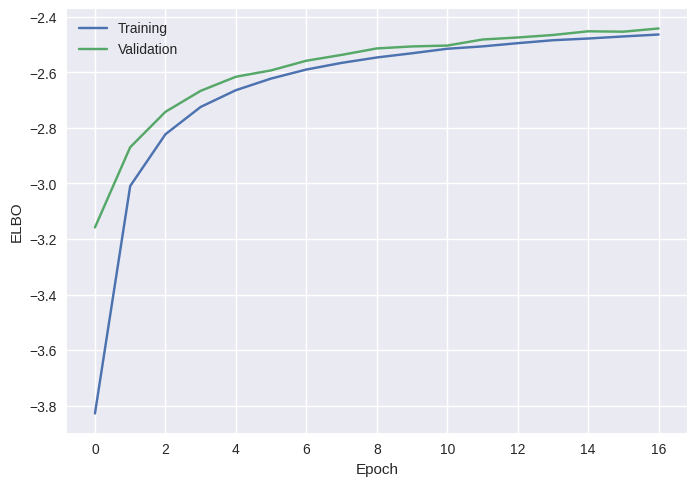

In [55]:
# Plot the training and validation loss curves
plot_ELBO(bernoulli_train_loss, bernoulli_val_loss)

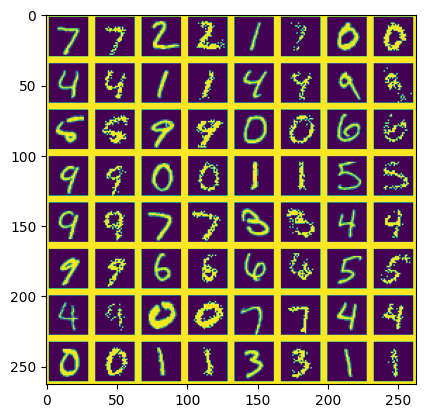

In [56]:
# Plot the reconstruction of test images
plot_reconstruction(vae_bernoulli, n_samples, img_size, test_samples, reconstruct=True)

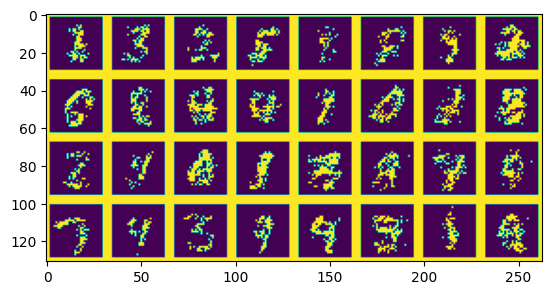

In [57]:
# Generate new images by sampling from the latent space
plot_reconstruction(vae_bernoulli, n_samples, img_size, reconstruct=False)

# Task 3

In [81]:
n_latent = 2
vae_gaussian_latent2 = GaussianVAE(n_latent, train_D)
stop_threshold = 1
stop_early = EarlyStopping(stop_threshold)
train_vae(vae_gaussian_latent2, stop_early)

 26%|▎| 26/100 [02:43<07:46,  6.30s/it, Train Loss=-7.05e+6, Validation Loss=-1.

Training criterion reached at epoch 26. Stopping training...


([-13.845388232574463,
  -72.1194268295288,
  -87.44691053466796,
  -94.93718884765624,
  -100.42865764160156,
  -104.91575567626953,
  -108.5725050805664,
  -112.2375269189453,
  -115.59830962402344,
  -118.36978529052735,
  -120.9703196484375,
  -123.34272899414063,
  -125.32548683105469,
  -127.2300164892578,
  -128.8358825439453,
  -130.35659826171874,
  -131.6296050805664,
  -132.50762658203126,
  -133.989812734375,
  -135.00034076660157,
  -135.96164119628907,
  -137.03774317871094,
  -137.89554979492186,
  -138.93814455566405,
  -139.73016400390625,
  -140.49322159179687,
  -141.07478290039063],
 [-64.18005319213867,
  -88.16144012451171,
  -98.46747396240234,
  -104.17614985351562,
  -107.75411474609375,
  -112.63681828613281,
  -113.09395942382812,
  -120.11454392089844,
  -124.09350327148438,
  -123.3493046875,
  -128.53131044921875,
  -128.36428330078124,
  -132.3833580810547,
  -135.99200029296875,
  -131.17176162109374,
  -138.43171171875,
  -139.8746119628906,
  -140.4207

In [82]:
from torch import Tensor
import matplotlib as mpl
from sklearn.decomposition import PCA

def plot_latent_space(encoder: Module, test_x: Tensor, test_labels: Tensor, use_pca=False):
    """
    Display a 2D plot of the digit classes in the latent space
    :param encoder: encoder network extending torch.nn.Module
    :param test_x: test image data
    :param test_labels: test image labels [0-9]
    :param use_pca: whether to use PCA to reduce the dimensionality of the latent space
    :return:
    """
    z, _, _ = encoder(test_x)
    values = z.detach().cpu().numpy()
    plt.style.use('default')
    plt.figure(figsize=(12, 10))

    if use_pca:
        pca = PCA(n_components=2)
        values = pca.fit_transform(values)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
    else:
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")

    c_map = mpl.cm.viridis
    bounds = np.linspace(0, 9, 10)
    norm = mpl.colors.BoundaryNorm(bounds, c_map.N, extend='both')
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=c_map))
    plt.scatter(values[:, 0], values[:, 1], c=test_labels)
    plt.show()

In [83]:
test_input = test_x.reshape(test_x.shape[0], img_size, img_size).unsqueeze(1)

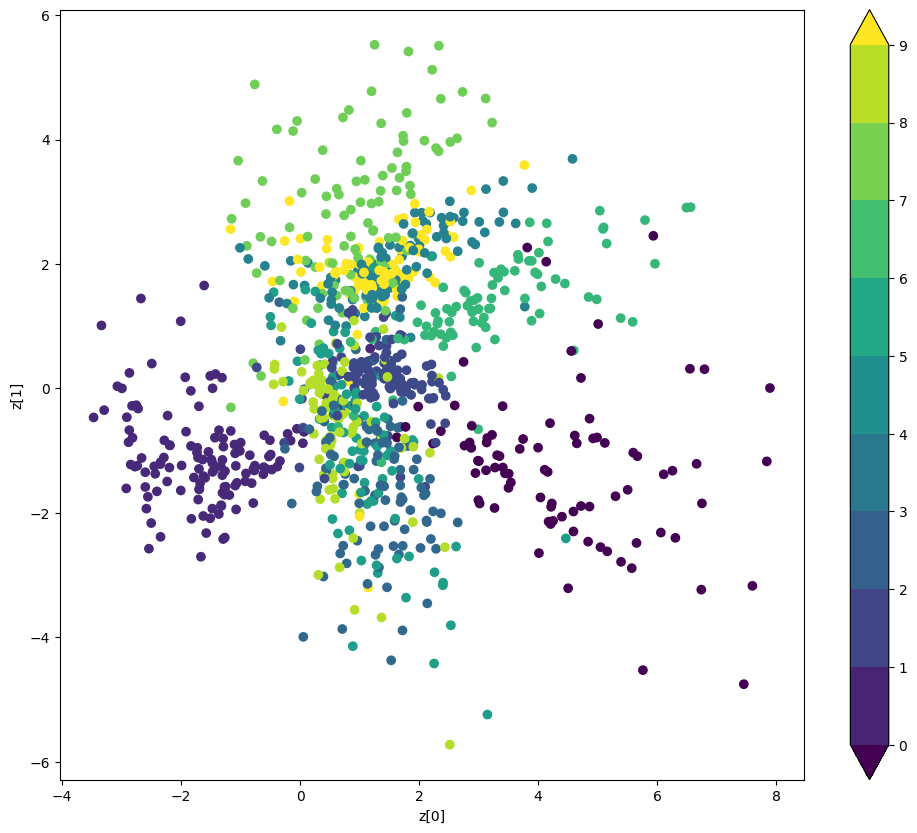

In [84]:
plot_latent_space(vae_gaussian_latent2.encoder, test_input[:1000], test_labels[:1000])

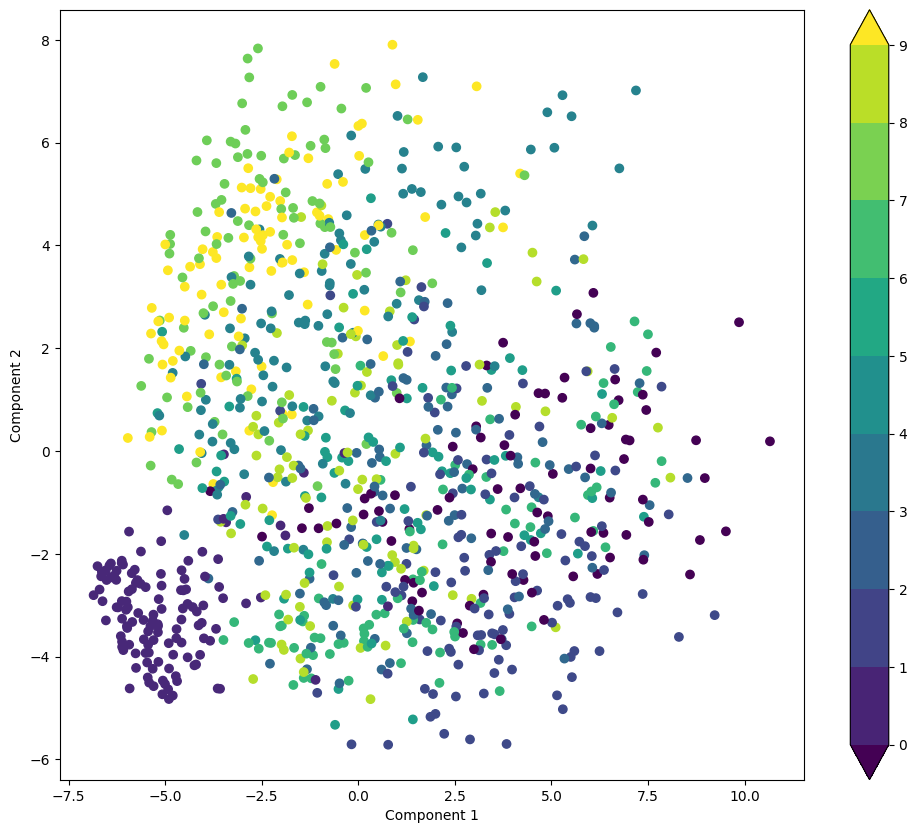

In [94]:
plot_latent_space(vae_beta.encoder, test_input[:1000], test_labels[:1000], use_pca=True)

In [60]:
def plot_interpolation(vae: VAE, test_x: Tensor, test_labels: Tensor, img_size: int, k=15):
    """
    Plot interpolation between two pair-wise sampled digits in the latent space.
    :param vae: VAE model
    :param test_x: test image data
    :param test_labels: test image labels [0-9]
    :param img_size: number of pixels of the width/height of the square MNIST digit image
    :param k: number of digit pairs to interpolate between
    """
    # 1D linearly spaced partition
    lin_space = np.linspace(0, 1, k)
    figure = np.zeros((img_size * k, img_size * k))
    row = 0
    while row < k:
        # Sample two digits
        indices = np.random.choice(len(test_x), 2)
        # Re-sample the indices if the labels are the same
        if test_labels[indices[0]] == test_labels[indices[1]]:
            continue

        x1 = test_x[indices[0]].reshape(1, 1, img_size, img_size)
        x2 = test_x[indices[1]].reshape(1, 1, img_size, img_size)

        for j, lambda_ in enumerate(lin_space):

            z1, _, _ = vae.encode(x1)
            z2, _, _ = vae.encode(x2)

            # Interpolate between the two latent vectors
            z = lambda_ * z1 + (1 - lambda_) * z2

            x_hat = vae.decoder.reconstruct(z)
            x_hat = x_hat.reshape(img_size, img_size).detach().cpu().numpy()

            # Plot the interpolated digit
            figure[row * img_size: (row + 1) * img_size, j * img_size: (j + 1) * img_size] = x_hat
        row += 1

    plt.style.use('default')
    plt.figure(figsize=(10, 10))
    start_range = img_size // 2
    end_range = k * img_size - start_range + 1
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(lin_space, 2)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks([])
    plt.xlabel("lambda")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

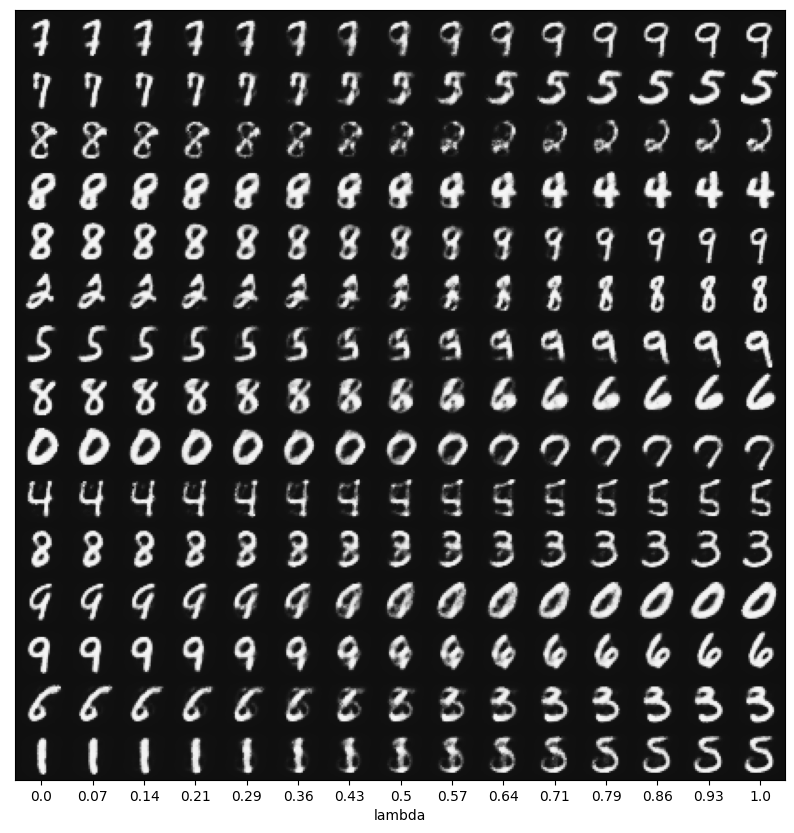

In [102]:
plot_interpolation(vae_beta, test_input, test_labels, img_size)